# Generate annual/yearly zarr stores from hourly ERA5 data files

In [1]:
import glob
import re
import matplotlib as plt
import numpy as np
import scipy as sp
import xarray as xr
import intake
import intake_esm

In [2]:
import dask
from dask.distributed import Client, performance_report
from dask_jobqueue import PBSCluster

In [3]:
# File paths
rda_scratch = "/gpfs/csfs1/collections/rda/scratch/harshah"
rda_data    = "/gpfs/csfs1/collections/rda/data/"
#########
rda_url           = 'https://data.rda.ucar.edu/'
era5_catalog      = rda_url + 'pythia_era5_24/pythia_intake_catalogs/era5_catalog.json'
#alternate_catalog = rda_data + 'pythia_era5_24/pythia_intake_catalogs/era5_catalog_opendap.json'
annual_means      =  rda_url + 'pythia_era5_24/annual_means/'
########
zarr_path   = rda_scratch + "/tas_zarr/"
##########
print(era5_catalog)

https://data.rda.ucar.edu/pythia_era5_24/pythia_intake_catalogs/era5_catalog.json


## Spin up a PBS cluster

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch +'/dask/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '3:30:00',
    #interface = 'ib0'
    interface = 'ext'
)

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.94:38659,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
cluster.scale(10)

## Find data using intake catalog 

In [7]:
era5_cat = intake.open_esm_datastore(era5_catalog)
era5_cat

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/intake_esm/cat.py:251: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,unique
era_id,1
datatype,2
level_type,1
step_type,7
table_code,4
param_code,164
variable,212
long_name,212
units,33
year,85


### Select variable of interest

In [10]:
temp_cat = era5_cat.search(variable='VAR_2T',frequency = 'hourly')
temp_cat

,unique
era_id,1
datatype,1
level_type,0
step_type,1
table_code,1
param_code,1
variable,1
long_name,1
units,1
year,85


In [11]:
# Define the xarray_open_kwargs with a compatible engine, for example, 'scipy'
xarray_open_kwargs = {
    'engine': 'h5netcdf',
    'chunks': {},  # Specify any chunking if needed
    'backend_kwargs': {}  # Any additional backend arguments if required
}

In [12]:
# %%time
# dsets = temp_cat.to_dataset_dict(xarray_open_kwargs=xarray_open_kwargs)

In [13]:
dsets.keys()

NameError: name 'dsets' is not defined

In [ ]:
temp_2m = dsets['an.sfc'].VAR_2T
temp_2m

In [ ]:
# temp_2m_annual = temp_2m.resample(time='1Y').mean()
# temp_2m_annual

In [14]:
temp_2m_monthly = xr.open_zarr(zarr_path + "e5_tas2m_monthly_1940_2023.zarr").VAR_2T
temp_2m_monthly

<xarray.DataArray 'VAR_2T' (time: 1009, latitude: 721, longitude: 1440)>
dask.array<open_dataset-VAR_2T, shape=(1009, 721, 1440), dtype=float32, chunksize=(1000, 721, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-01-31 1940-02-29 ... 2024-01-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [15]:
temp_2m_annual = temp_2m_monthly.resample(time='1Y').mean()
temp_2m_annual = temp_2m_annual.chunk({'latitude':721,'longitude':1440})
temp_2m_annual

<xarray.DataArray 'VAR_2T' (time: 85, latitude: 721, longitude: 1440)>
dask.array<rechunk-merge, shape=(85, 721, 1440), dtype=float32, chunksize=(85, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

#### Save annual mean to pythia_era5_24/annual_means folder within rda_data

In [ ]:
# %%time
# temp_2m_annual.to_dataset().to_zarr(annual_means + 'temp_2m_annual_1940_2023.zarr',mode='w')

In [16]:
temp_2m_annual = xr.open_zarr(annual_means + 'temp_2m_annual_1940_2023.zarr').VAR_2T
temp_2m_annual

<xarray.DataArray 'VAR_2T' (time: 85, latitude: 721, longitude: 1440)>
dask.array<open_dataset-VAR_2T, shape=(85, 721, 1440), dtype=float32, chunksize=(85, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1940-12-31 1941-12-31 ... 2024-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

CPU times: user 406 ms, sys: 49.1 ms, total: 455 ms
Wall time: 8.38 s


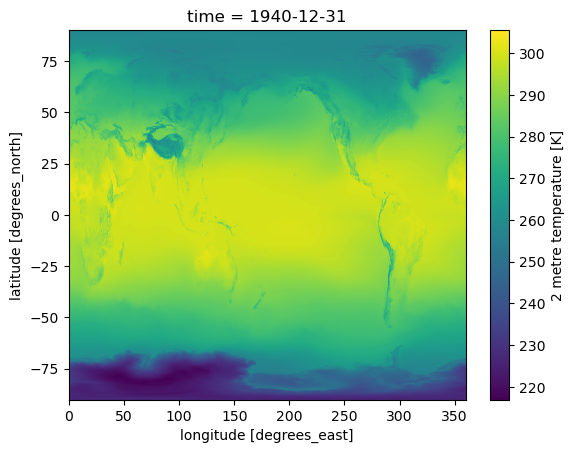

In [17]:
%%time
temp_2m_annual.isel(time=0).plot()

### Close up the cluster

In [ ]:
# cluster.close()